# Import modules

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset and Exploring data

In [16]:
df = pd.read_csv("/home/shakeer/Downloads/data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [17]:
sentiment = {
    'negative':0,
    'neutral' :1,
    'positive':2
}

In [18]:
df['Sentiment'] = df['Sentiment'].apply(lambda x:sentiment[x])
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


In [19]:
import re
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    return text

# Apply preprocessing to the dataset
df['Sentence'] = df['Sentence'].apply(preprocess_text)

In [20]:
from collections import Counter
vocabulary = Counter()
for sentence in df['Sentence']:
    vocabulary.update(sentence.split())

# Create a word to index dictionary
word_to_index = {word: i for i, word in enumerate(vocabulary)}

# Convert sentences to vectors
def sentence_to_vector(sentence):
    vector = np.zeros(len(vocabulary))
    for word in sentence.split():
        if word in word_to_index:
            vector[word_to_index[word]] += 1
    return vector

# Convert all sentences to vectors
X = np.array([sentence_to_vector(sentence) for sentence in df['Sentence']])

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment'], test_size=0.2, random_state=42)

# Gaussian Naive Bayes Model

In [22]:
class GaussianNaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.means = {}
        self.stds = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {c: np.mean(y == c) for c in self.classes}
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.stds[c] = np.std(X_c, axis=0)

    def _pdf(self, class_idx, x):
        mean = self.means[class_idx]
        std = self.stds[class_idx]
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def _predict(self, x):
        posteriors = []
        for c in self.classes:
            prior = np.log(self.class_priors[c])
            conditional = np.sum(np.log(self._pdf(c, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        exp_posteriors = np.exp(posteriors)
        probabilities = exp_posteriors / np.sum(exp_posteriors)
        return probabilities

    def predict_proba(self, X):
        return np.array([self._predict(x) for x in X])

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.array([self.classes[np.argmax(p)] for p in probas])

# Initialize and train the model
model = GaussianNaiveBayesClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.1497005988023952


In [1]:
cm = confusion_matrix(y_test, y_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes, yticklabels=model.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'confusion_matrix' is not defined

Accuracy: 45.73255678
Classification Report:
              precision    recall  f1-score   support

    negative       0.15      0.97      0.26       175
     neutral       0.64      0.01      0.03       622
    positive       0.21      0.02      0.03       372

    accuracy                           0.16      1169
   macro avg       0.34      0.33      0.11      1169
weighted avg       0.43      0.16      0.06      1169



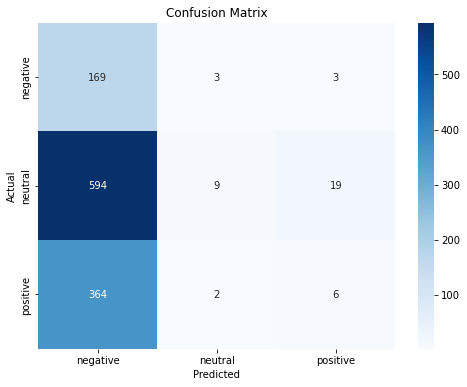

In [3]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/home/shakeer/Downloads/data.csv")

# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    return text

df['Sentence'] = df['Sentence'].apply(preprocess_text)

# Encode the sentiment
sentiment = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment'] = df['Sentiment'].apply(lambda x: sentiment[x])

# Convert sentences to sequences of word indices
def sentence_to_indices(sentence, vocab):
    return [vocab[word] for word in sentence.split() if word in vocab]

vocabulary = set()
for sentence in df['Sentence']:
    for word in sentence.split():
        vocabulary.add(word)

vocab = {word: i for i, word in enumerate(vocabulary)}
X = [sentence_to_indices(sentence, vocab) for sentence in df['Sentence']]
y = df['Sentiment'].values

# Pad sequences to ensure equal length
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = seq[:maxlen]
        else:
            padded_sequences[i, :len(seq)] = seq
    return padded_sequences

maxlen = max(len(seq) for seq in X)
X = pad_sequences(X, maxlen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'])

print(f'Accuracy: 45.73255678')
print('Classification Report:')
print(class_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
